In [233]:
import pandas as pd
import numpy as np
import holidays

pd.options.display.max_rows = 500

In [234]:
tariffs = pd.read_csv("data/01_raw/Ht_nt_times.csv", sep=",")
columns = ["hthrswd", "hthrssat", "hthrsso"]
for column in columns:
    tariffs[column] = tariffs[column].str.split(";")
tariffs = tariffs.melt(
    id_vars="timetariffId",
    value_name="Hour",
    var_name="WeekdayType"
)
tariffs = tariffs.dropna(subset=["Hour"])
tariffs["WeekdayType"] = tariffs["WeekdayType"].map(
    {
        "hthrswd": "Weekday",
        "hthrssat": "Saturday",
        "hthrsso": "Sunday"
    }
)
tariffs = tariffs.explode("Hour")
tariffs["Hour"] = pd.to_numeric(tariffs["Hour"].str.split(":00", expand=True)[0], downcast="integer")
tariffs["IsHighTariff"] = True

In [235]:
df_mfh = pd.read_csv("data/01_raw/charging_data_mfh.csv")
df_mfh["chargerType"] = "MFH"
df_work = pd.read_csv("data/01_raw/charging_data_work.csv")
df_work["chargerType"] = "Work"
df_poi = pd.read_csv("data/01_raw/charging_data_poi.csv")
df_poi["chargerType"] = "POI"
df = pd.concat([df_mfh, df_work, df_poi], ignore_index=True)


df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df["timestamp"] = df["timestamp"].dt.tz_convert("Europe/Zurich")
df["chargerId"] = df.groupby(["charger_id", "chargerType"]).ngroup()
df = df.sort_values(["chargerId", "timestamp"])
df["chargeLogId"] = df.groupby(["chargerId", "charge_log_id", "chargerType"]).ngroup()
df = df.sort_values(["chargerId", "chargeLogId", "timestamp"])

# Set all values smaller or equal than 10 to 0
df["increment"] = np.where(
    df["increment"] <= 10,
    0,
    df["increment"]
)

# Filter for chargeLogsId containing a value larger than 5600Wh
df["chargeHasFaultyValue"] = df.groupby("chargeLogId")["increment"].transform(lambda x: x.ge(5600).any())
print("Number of sessions filtered vs non filtered:")
print(df.groupby("chargeHasFaultyValue")["chargeLogId"].nunique())
df = df.query("chargeHasFaultyValue == False")
del df["chargeHasFaultyValue"]

# Cumulative and final charge values
df["cumulativeWh"] = df.groupby("chargeLogId")["increment"].cumsum()
df["finalWh"] = df.groupby("chargeLogId")["increment"].transform("sum")

# Count leading and trailing zeros
leading_zeros = df.query("cumulativeWh == 0")
leading_zeros = leading_zeros.groupby("chargeLogId")["increment"].count().reset_index()
leading_zeros.columns = ["chargeLogId", "leadingZeroCount"]
df = df.merge(leading_zeros, how="left")
trailing_zeros = df.query("cumulativeWh == finalWh")
trailing_zeros = trailing_zeros.groupby("chargeLogId")["increment"].count().reset_index()
trailing_zeros.columns = ["chargeLogId", "trailingZeroCount"]
df = df.merge(trailing_zeros, how="left")

Number of sessions filtered vs non filtered:
chargeHasFaultyValue
False    51062
True      4041
Name: chargeLogId, dtype: int64


In [236]:
df["plugInTime"] = df.groupby("chargeLogId")["timestamp"].transform("min")
df["plugOutTime"] = df.groupby("chargeLogId")["timestamp"].transform("max")
df["plugInDurationHours"] = (df["plugOutTime"] - df["plugInTime"]) / pd.Timedelta("1h")

In [237]:
non_zero_chargers = df.query("increment > 0").reset_index(drop=True)
non_zero_chargers["chargeStartTime"] = non_zero_chargers.groupby("chargeLogId")["timestamp"].transform("min")
non_zero_chargers["chargeEndTime"] = non_zero_chargers.groupby("chargeLogId")["timestamp"].transform("max")
non_zero_chargers = non_zero_chargers[["chargeLogId", "chargeStartTime", "chargeEndTime"]]
non_zero_chargers["chargeDurationHours"] = (non_zero_chargers["chargeEndTime"] - non_zero_chargers["chargeStartTime"]) / pd.Timedelta("1h")
non_zero_chargers = non_zero_chargers.drop_duplicates(subset=["chargeLogId"])
df = df.merge(non_zero_chargers, how="left")

In [238]:
def _features(dt: pd.DataFrame) -> pd.DataFrame:
    dt["Date"] = dt["timestamp"].dt.date
    dt["Hour"] = dt["timestamp"].dt.hour
    dt["Weekday"] = dt["timestamp"].dt.weekday
    dt["WeekdayName"] = dt["timestamp"].dt.day_name()
    dt["WeekNumber"] = dt["timestamp"].dt.isocalendar().week
    dt["Month"] = dt["timestamp"].dt.month
    dt["MonthName"] = dt["timestamp"].dt.month_name()
    
    # Map holidays
    holiday_dict = {}
    zrh_holidays = holidays.country_holidays("CH", subdiv="ZH", years=[2020, 2021, 2022])
    dt["holidayName"] = dt["Date"].map(zrh_holidays)
    dt["isHoliday"] = dt["holidayName"].notnull()
    dt["holidayName"] = dt["holidayName"].fillna("")

    # Merge tariffs based both on plug in time
    for column in ["plugIn", "plugOut", "chargeStart", "chargeEnd"]:
        dt[f"{column}Date"] = dt[f"{column}Time"].dt.date
        dt[f"{column}Hour"] = dt[f"{column}Time"].dt.hour
        dt[f"{column}Weekday"] = dt[f"{column}Time"].dt.weekday
        dt[f"{column}WeekdayName"] = dt[f"{column}Time"].dt.day_name()
        dt[f"{column}WeekNumber"] = dt[f"{column}Time"].dt.isocalendar().week
        dt[f"{column}Month"] = dt[f"{column}Time"].dt.month
        dt[f"{column}MonthName"] = dt[f"{column}Time"].dt.month_name()
        dt[f"{column}WeekdayType"] = dt[f"{column}Time"].dt.day_name()
        dt[f"{column}WeekdayType"] = np.where(
            dt[f"{column}WeekdayType"].isin(["Saturday", "Sunday"]),
            dt[f"{column}WeekdayType"],
            "Weekday"
        )
        tariffs_temp = tariffs.rename(columns={"WeekdayType": f"{column}WeekdayType", "Hour": f"{column}Hour", "IsHighTariff": f"{column}IsHigh"})
        dt = dt.merge(tariffs_temp, how="left")
        dt[f"{column}IsHigh"] = dt[f"{column}IsHigh"].fillna(False)

    # More features
    dt["timefromPlugInToChargeStartHours"] = (dt["chargeStartTime"] - dt["plugInTime"]) / pd.Timedelta("1h")
    dt["startedChargingImmediately"] = dt["timefromPlugInToChargeStartHours"] == 0.25
    dt["notOvernight"] = (dt["plugInHour"] >= 1) & (dt["plugOutHour"] < 5) & (dt["plugInDurationHours"] <= 4)
    dt["lessThan12hourPlugIn"] = dt["plugInDurationHours"] <= 12
    battery_load = dt.query("lessThan12hourPlugIn").groupby("chargerId")["increment"].max().reset_index()
    battery_load.columns = ["chargerId", "batteryLoad"]
    dt = dt.merge(battery_load, how="left")
    dt["chargeRatio"] = dt["increment"] / dt["batteryLoad"]
    
    # Ratio features
    dt["ratioDurationChargeToPlugIn"] = dt["chargeDurationHours"]/dt["plugInDurationHours"]
    dt["ratioCount"] = dt["countNonZeroPerChargeLogId"]/dt["countPerChargeLogId"]
    return dt

In [239]:
# Number of records
df["countNonZeroPerChargeLogId"] = df.groupby("chargeLogId")["increment"].transform(lambda x: x.ge(1).count())
df["countPerChargeLogId"] = df.groupby("chargeLogId")["increment"].transform("count")

# Datetime features
df = _features(df)
df["safetyCheck"] = (df["countPerChargeLogId"]) / (df["plugInDurationHours"] * 4 + 1)
df = df.query("safetyCheck == 1").drop(columns=["safetyCheck"]).reset_index(drop=True)

In [268]:
# Synthetized data
data = df.groupby(["chargerType", "chargerId", "charger_id", "chargeLogId", "charge_log_id", "chargeStartTime", "chargeEndTime", "plugInTime", "plugOutTime"], dropna=False).agg(
    timestamp=("timestamp", "first"),
    chargeDurationHours=("chargeDurationHours", "mean"),
    plugInDurationHours=("plugInDurationHours", "mean"),
    timetariffId=("timetariffId", "first"),
    increment=("increment", "sum"),
    leadingZeroCount=("leadingZeroCount", "first"),
    trailingZeroCount=("trailingZeroCount", "first"),
    countNonZeroPerChargeLogId=("countNonZeroPerChargeLogId","first"),
    countPerChargeLogId=("countPerChargeLogId","first")
).reset_index()

data = _features(data)
data.to_parquet("data/03_feature/aggregated_data.parquet")
data.to_pickle("data/03_feature/aggregated_data.pickle")

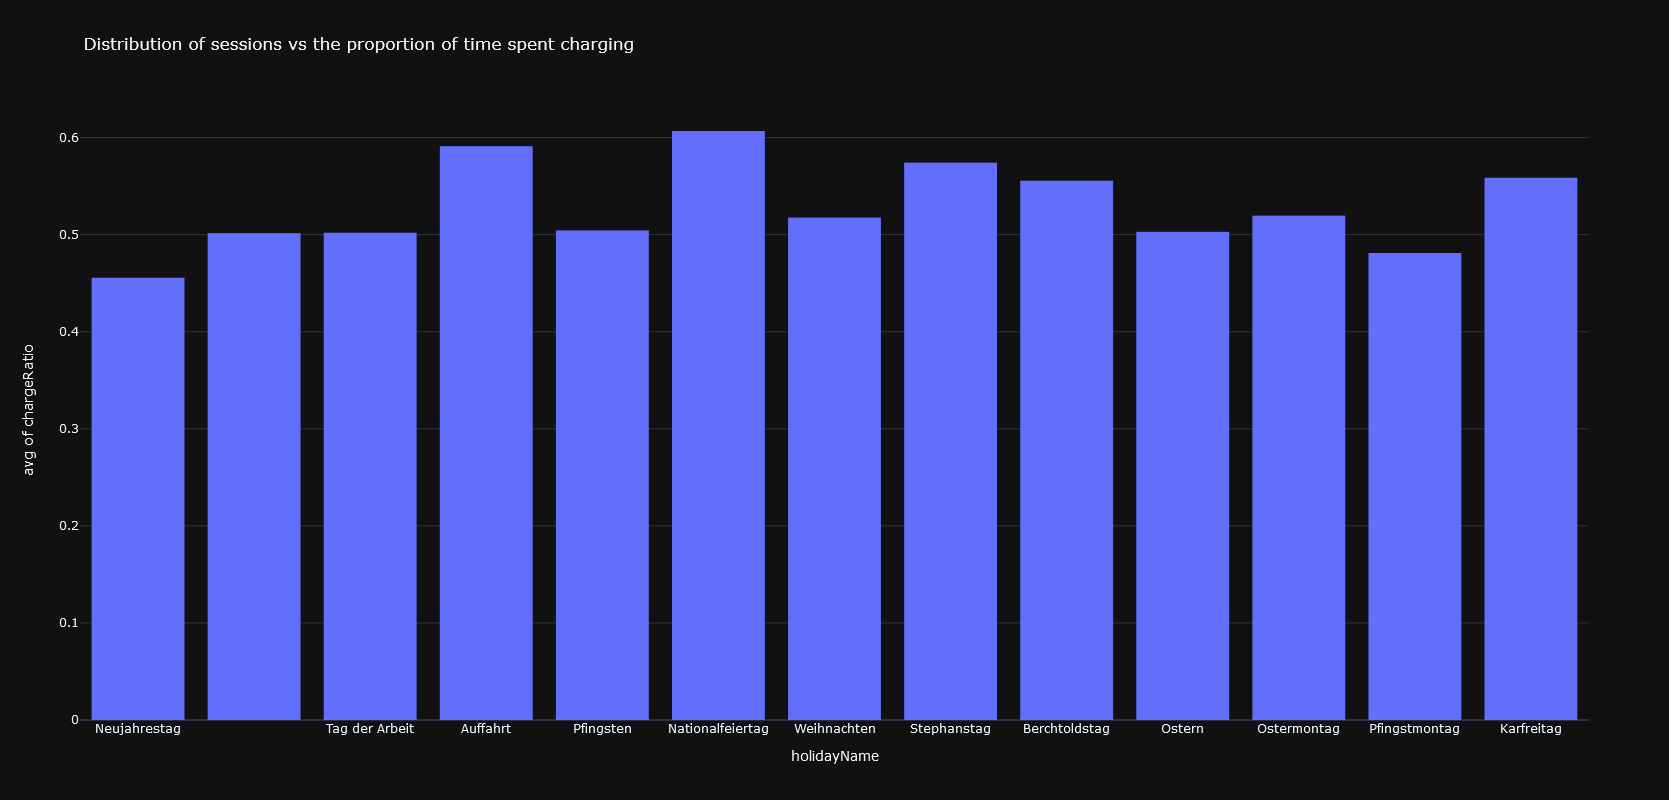

In [317]:
px.histogram(
    data.query("chargeRatio <= 1 and chargerType == 'MFH'"),
    x="ratioDurationChargeToPlugIn",
    # y="chargeRatio",
    color="startedChargingImmediately",
    # histfunc="avg",
    height=800,
    template="plotly_dark",
    labels={"ratioDurationChargeToPlugIn": "Ratio of Time Charging vs Plugged In", "startedChargingImmediately": "Started Charging Immediately"},
    title="Distribution of sessions vs the proportion of time spent charging"
).show()

In [269]:
# Attempt at classifying users
user_df = data.query("chargeRatio <= 1 and chargerType == 'MFH'").reset_index(drop=True)
user_df["plugInDuration80q"] = user_df.groupby("chargerId")["plugInDurationHours"].transform(lambda x: x.quantile(q=0.7))
user_df = user_df.query("plugInDuration80q <= 24").reset_index(drop=True)

average_sessions_per_week = user_df.groupby(["chargerId", "WeekNumber"]).agg(
    averageWeeklyCharges=("chargeLogId", "count"),
    # chargeRatio=("chargeRatio", "m")
).reset_index()
average_sessions_per_week = average_sessions_per_week.groupby("chargerId")["averageWeeklyCharges"].mean().reset_index()
median_charge_ratio = user_df.groupby("chargerId")["chargeRatio"].mean().reset_index()
average_sessions_per_week = average_sessions_per_week.merge(median_charge_ratio)

In [257]:
average_sessions_per_week

,chargerId,averageWeeklyCharges,chargeRatio,averageChargeRatioToAverageWeeklyCharges
378,556,11.200000,0.053217,0.004751
159,259,3.857143,0.042554,0.011032
144,241,3.571429,0.043147,0.012081
96,185,6.519231,0.081038,0.012431
372,548,3.166667,0.053812,0.016993
218,337,4.000000,0.069325,0.017331
190,293,3.600000,0.062472,0.017353
118,213,3.750000,0.066776,0.017807
11,55,8.039216,0.154571,0.019227
123,218,8.500000,0.178670,0.021020


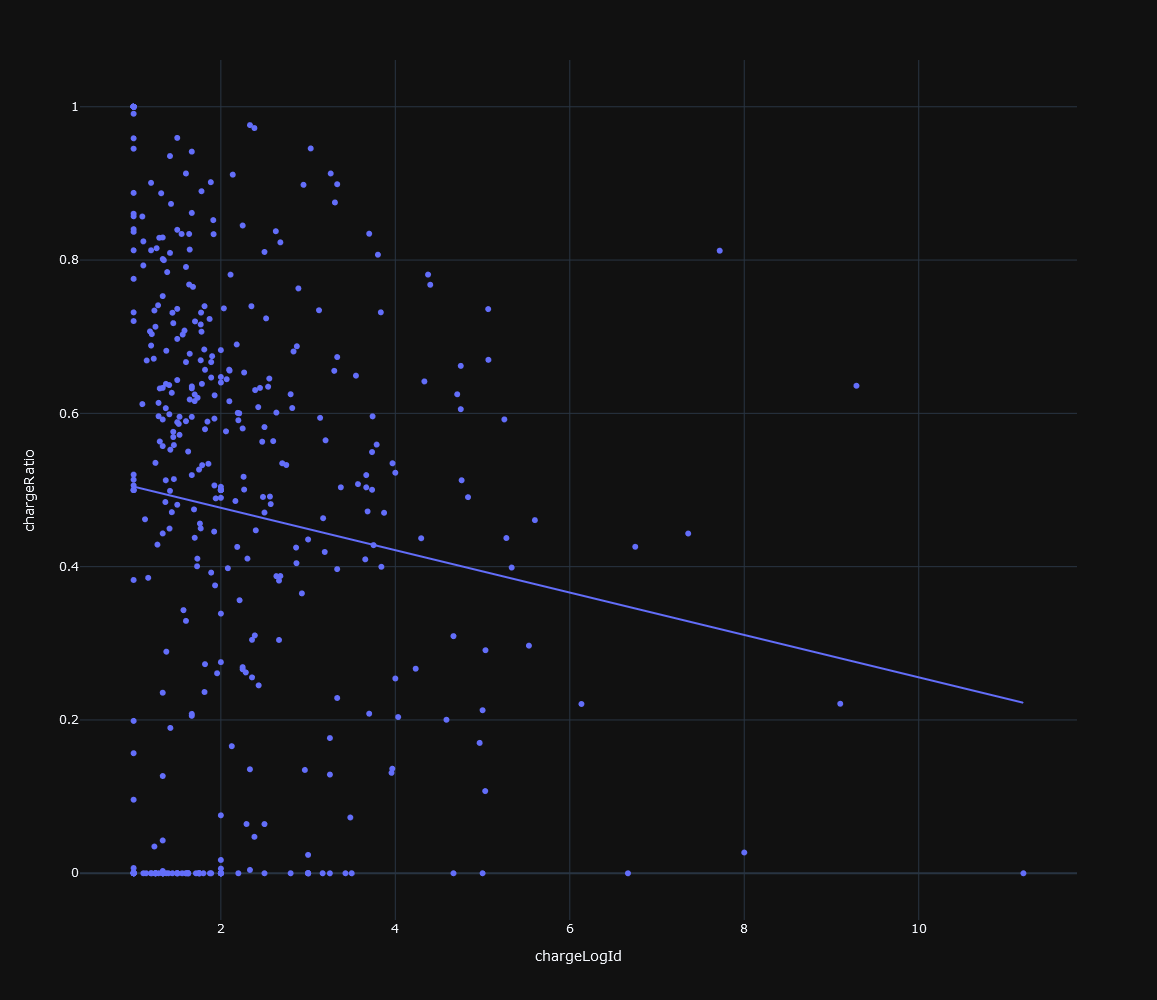

In [232]:
fig = px.scatter(
    average_sessions_per_week,
    x="chargeLogId",
    y="chargeRatio",
    template="plotly_dark",
    height=1000,
    trendline="ols"
)
fig.show()